In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, roc_curve)
import pandas as pd

# Paths to audio files
anomalous_audio_path = "../Data/raw/11_A_09_experiment7/A_09_10_experiment7_8.wav"
normal_audio_path = "../Data/raw/11_A_09_experiment7/N_09_experiment7.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../Data/frames/anomalous_frames.npy"
output_normal_frames_path = "../Data/frames/normal_frames.npy"
train_frames_path = "../Data/datasets/train_frames.npy"
val_frames_path = "../Data/datasets/val_frames.npy"
test_frames_path = "../Data/datasets/test_frames.npy"
test_labels_path = "../Data/datasets/test_labels.npy"

# Ensure necessary directories exist
os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)


In [2]:
# Function to generate a normalized Mel-spectrogram
def generate_mel_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    return mel_db_norm, sr

# Function to generate overlapping frames from a Mel-spectrogram
def generate_frames(mel_spectrogram, frame_size, hop_size):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames

# Adjustable parameters
time_per_frame = 0.4  # Duration of one frame in seconds
hop_ratio = 0.2       # Overlap ratio between frames

# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path)

# Ensure sampling rates match
assert sr_anomalous == sr_normal, "Sampling rates do not match!"

# Calculate frame and hop sizes
hop_length = 512
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size = int(frame_size * hop_ratio)

# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)


In [3]:
# Load frames
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

# Split normal frames into training and test sets
normal_train, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)

# Combine normal_test and anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

# Shuffle the test set
indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)


In [4]:
# Load datasets
X_train = np.load(train_frames_path)
X_test = np.load(test_frames_path)
y_test = np.load(test_labels_path)

# Flatten the frames
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

# Adjust labels: 1 for normal, -1 for anomalous
y_test = np.where(y_test == 0, 1, -1)


In [5]:
def classify_anomalies(train_data, test_data, test_labels, machine, feat_label):
    scaler = MinMaxScaler(feature_range=(-5, 5))
    
    # LOF without PCA
    lof = LocalOutlierFactor(novelty=True, contamination=0.1)
    lof_pipe = Pipeline([("scaler", scaler), ("classifier", lof)])
    
    # LOF with PCA
    pca_lof = PCA(0.9)
    lof_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_lof), ("classifier", lof)])
    
    # Isolation Forest without PCA
    isolation_forest = IsolationForest(contamination=0.1, random_state=42)
    isolation_forest_pipe = Pipeline([("scaler", scaler), ("classifier", isolation_forest)])
    
    # Isolation Forest with PCA
    pca_if = PCA(0.9)
    isolation_forest_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_if), ("classifier", isolation_forest)])
    
    models = {
        "LOF": lof_pipe,
        "LOF + PCA": lof_pca_pipe,
        "Isolation Forest": isolation_forest_pipe,
        "Isolation Forest + PCA": isolation_forest_pca_pipe,
    }
    
    results = {
        "Machine": machine,
        "Features": feat_label,
        "Model": [],
        "AUC": [],
        "Recall": [],
        "Precision": [],
        "Abnormal (-1) F1": [],
    }
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(16, 4))

    for i, (model_name, model) in enumerate(models.items()):
        roc_ax = axes[i]
        model.fit(train_data)
        scores = model.decision_function(test_data)
        auc = roc_auc_score(test_labels, scores)
        fpr, tpr, thresholds = roc_curve(test_labels, scores)
        
        roc_ax.plot(fpr, tpr)
        roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)
        roc_ax.set_title(f'{model_name}\n ROC Curve\n AUC = {auc:.2f}')
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.legend(['ROC curve', 'Random'], fontsize="9", loc='lower right')

        # Threshold for 85% correctly classified normal data
        sorted_scores = np.sort(scores[test_labels == 1])
        threshold_index = int(0.85 * len(sorted_scores))
        threshold = sorted_scores[threshold_index]
        predictions = np.where(scores >= threshold, 1, -1)

        recall = recall_score(test_labels, predictions, pos_label=-1)
        precision = precision_score(test_labels, predictions, pos_label=-1)
        abf1 = f1_score(test_labels, predictions, pos_label=-1)
        
        results["Model"].append(model_name)
        results["AUC"].append(auc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["Abnormal (-1) F1"].append(abf1)

    results_df = pd.DataFrame(results)
    print(f"{feat_label} features were reduced to {pca_lof.n_components_} components for LOF")
    print(f"{feat_label} features were reduced to {pca_if.n_components_} components for Isolation Forest")
    plt.tight_layout()
    plt.show()
    
    return results_df


c:\Users\s.krummenacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\s.krummenacher\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Mel-Spectrogram Frames features were reduced to 2018 components for LOF
Mel-Spectrogram Frames features were reduced to 2018 components for Isolation Forest


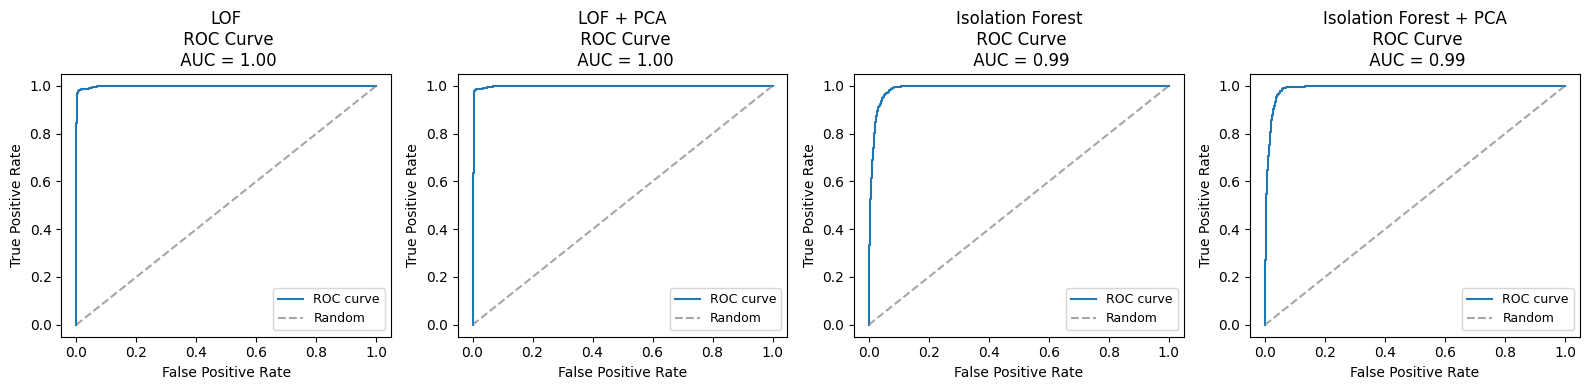

              Machine                Features                   Model  \
0  Hydropower Machine  Mel-Spectrogram Frames                     LOF   
1  Hydropower Machine  Mel-Spectrogram Frames               LOF + PCA   
2  Hydropower Machine  Mel-Spectrogram Frames        Isolation Forest   
3  Hydropower Machine  Mel-Spectrogram Frames  Isolation Forest + PCA   

        AUC    Recall  Precision  Abnormal (-1) F1  
0  0.998777  1.000000   0.681498          0.810585  
1  0.997136  0.999667   0.681426          0.810424  
2  0.987972  0.999334   0.681354          0.810263  
3  0.989782  0.999334   0.681354          0.810263  


In [6]:
results_df = classify_anomalies(X_train, X_test, y_test, "Hydropower Machine", "Mel-Spectrogram Frames")
print(results_df)


In [7]:
# Identify indices
correctly_classified_anomalies = np.where((test_labels == 1) & (predictions == 1))[0]
wrongly_classified_anomalies = np.where((test_labels == 1) & (predictions == 0))[0]
wrongly_classified_normals = np.where((test_labels == 0) & (predictions == 1))[0]

# Select up to 5 samples from each category
num_samples = 5
correct_anomaly_indices = correctly_classified_anomalies[:num_samples]
wrong_anomaly_indices = wrongly_classified_anomalies[:num_samples]
wrong_normal_indices = wrongly_classified_normals[:num_samples]

# Function to plot specified frames
def plot_specified_frames(frames, indices, title_prefix="Frame"):
    num_frames = len(indices)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i, idx in enumerate(indices):
        ax = axes[i] if num_frames > 1 else axes
        img = librosa.display.specshow(frames[idx], x_axis=None, y_axis="mel", cmap="viridis", ax=ax)
        ax.set_title(f"{title_prefix} {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Plot 5 correctly classified anomalies
print("Correctly Classified Anomalies:")
plot_specified_frames(test_frames, correct_anomaly_indices, title_prefix="Correct Anomaly")

# Plot 5 wrongly classified anomalies
print("Wrongly Classified Anomalies:")
plot_specified_frames(test_frames, wrong_anomaly_indices, title_prefix="Wrong Anomaly")

# Plot 5 wrongly classified normal frames
print("Wrongly Classified Normal Frames:")
plot_specified_frames(test_frames, wrong_normal_indices, title_prefix="Wrong Normal")

NameError: name 'predictions' is not defined

# **Preprocessing Pipeline**

In [1]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt

## **1. Synchronization of recorded audio files**

In [ ]:
# Load and synchronize audio files
audio_pi1, sr1 = librosa.load("../Data/raw/output_2024-10-17_171402.158245.wav", sr=None)
print("Pi1 audio loaded.")

audio_pi2, sr2 = librosa.load("../Data/raw/Valentin2.wav", sr=None)
print("Pi2 audio loaded.")


# Load and synchronize anomalous audio files
Aaudio_pi1, sr1 = librosa.load("../Data/raw/pi1_Aaudio.wav", sr=None)
print("Pi1 Aaudio loaded.")

Aaudio_pi2, sr2 = librosa.load("../Data/raw/pi2_Aaudio.wav", sr=None)
print("Pi2 Aaudio loaded.")

In [8]:
# Ensure the sample rates match
if sr1 != sr2:
    raise ValueError("Sample rates of the two files do not match")

# Trim silence
print("Trimming silence from both audio files...")
audio_pi1, _ = librosa.effects.trim(audio_pi1)
audio_pi2, _ = librosa.effects.trim(audio_pi2)
Aaudio_pi1, _ = librosa.effects.trim(Aaudio_pi1)
Aaudio_pi2, _ = librosa.effects.trim(Aaudio_pi2)

# Synchronize normal audio files
print("Computing cross-correlation for normal recordings...")
correlation_normal = fftconvolve(audio_pi1, audio_pi2[::-1], mode='full')
lag_normal = np.argmax(correlation_normal) - len(audio_pi2)
print(f"Detected delay for normal recordings: {lag_normal / sr1} seconds")

# Align normal audio files based on the lag
print("Aligning normal audio files...")
if lag_normal > 0:
    aligned_pi1 = audio_pi1[lag_normal:]
    aligned_pi2 = audio_pi2
else:
    aligned_pi1 = audio_pi1
    aligned_pi2 = audio_pi2[-lag_normal:]

min_length_normal = min(len(aligned_pi1), len(aligned_pi2))
aligned_pi1 = aligned_pi1[:min_length_normal]
aligned_pi2 = aligned_pi2[:min_length_normal]

# Save aligned normal audio files
#sf.write("aligned_pi1.wav", aligned_pi1, sr1)
#sf.write("aligned_pi2.wav", aligned_pi2, sr1)

# Synchronize anomalous audio files
print("Computing cross-correlation for anomalous recordings...")
correlation_anomalous = fftconvolve(Aaudio_pi1, Aaudio_pi2[::-1], mode='full')
lag_anomalous = np.argmax(correlation_anomalous) - len(Aaudio_pi2)
print(f"Detected delay for anomalous recordings: {lag_anomalous / sr1} seconds")

# Align anomalous audio files based on the lag
print("Aligning anomalous audio files...")
if lag_anomalous > 0:
    aligned_Api1 = Aaudio_pi1[lag_anomalous:]
    aligned_Api2 = Aaudio_pi2
else:
    aligned_Api1 = Aaudio_pi1
    aligned_Api2 = Aaudio_pi2[-lag_anomalous:]

min_length_anomalous = min(len(aligned_Api1), len(aligned_Api2))
aligned_Api1 = aligned_Api1[:min_length_anomalous]
aligned_Api2 = aligned_Api2[:min_length_anomalous]

# Save aligned anomalous audio files
#sf.write("aligned_Api1.wav", aligned_Api1, sr1)
#sf.write("aligned_Api2.wav", aligned_Api2, sr1)

print("All processing and saving completed.")

Trimming silence from both audio files...
Computing cross-correlation for normal recordings...
Detected delay for normal recordings: -35.20156462585034 seconds
Aligning normal audio files...
Computing cross-correlation for anomalous recordings...
Detected delay for anomalous recordings: 40.390249433106575 seconds
Aligning anomalous audio files...
All processing and saving completed.


In [9]:
# Save the aligned normal audio files
print("Saving aligned normal audio files...")
sf.write("../Data/aligned/aligned_pi1.wav", aligned_pi1, sr1)
sf.write("../Data/aligned/aligned_pi2.wav", aligned_pi2, sr1)

# Save a stereo version of the aligned normal audio
combined_audio_normal = np.vstack((aligned_pi1, aligned_pi2))
sf.write("../Data/aligned/aligned_stereo_normal.wav", combined_audio_normal.T, sr1)

# Save the aligned anomalous audio files
print("Saving aligned anomalous audio files...")
sf.write("../Data/aligned/aligned_Api1.wav", aligned_Api1, sr1)
sf.write("../Data/aligned/aligned_Api2.wav", aligned_Api2, sr1)

# Save a stereo version of the aligned anomalous audio
combined_audio_anomalous = np.vstack((aligned_Api1, aligned_Api2))
sf.write("../Data/aligned/aligned_stereo_anomalous.wav", combined_audio_anomalous.T, sr1)

print("Processing and saving completed for all audio files.")

Saving aligned normal audio files...
Saving aligned anomalous audio files...
Processing and saving completed for all audio files.


## **2. Transformations (STFT & MEL)**

In [1]:
# Paths to your audio files in the aligned folder
audio_pi1_path = "../Data/aligned/WM_aligned_pi1.wav"
#audio_pi2_path = "../Data/aligned/WM_aligned_pi2.wav"
audio_Api1_path = "../Data/aligned/WM_aligned_Api1.wav"
audio_Api2_path = "../Data/aligned/WM_aligned_Api2.wav"

# Load aligned audio files
aligned_pi1, sr1 = librosa.load(audio_pi1_path, sr=None)
print("Aligned Pi1 normal audio loaded.")

aligned_pi2, sr2 = librosa.load(audio_pi1_path, sr=None)
print("Aligned Pi2 normal audio loaded.")

aligned_Api1, sr3 = librosa.load(audio_Api1_path, sr=None)
print("Aligned Pi1 anomalous audio loaded.")

aligned_Api2, sr4 = librosa.load(audio_Api2_path, sr=None)
print("Aligned Pi2 anomalous audio loaded.")


NameError: name 'librosa' is not defined

In [6]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_pi1 = librosa.stft(aligned_pi1, n_fft=1024, hop_length=512)
stft_pi2 = librosa.stft(aligned_pi2, n_fft=1024, hop_length=512)
stft_Api1 = librosa.stft(aligned_Api1, n_fft=1024, hop_length=512)
stft_Api2 = librosa.stft(aligned_Api2, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [8]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_pi1 = librosa.feature.melspectrogram(S=np.abs(stft_pi1), sr=sr1, n_mels=128)
mel_pi2 = librosa.feature.melspectrogram(S=np.abs(stft_pi2), sr=sr2, n_mels=128)
mel_Api1 = librosa.feature.melspectrogram(S=np.abs(stft_Api1), sr=sr3, n_mels=128)
mel_Api2 = librosa.feature.melspectrogram(S=np.abs(stft_Api2), sr=sr4, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_pi1 = librosa.power_to_db(mel_pi1, ref=np.max)
mel_db_pi2 = librosa.power_to_db(mel_pi2, ref=np.max)
mel_db_Api1 = librosa.power_to_db(mel_Api1, ref=np.max)
mel_db_Api2 = librosa.power_to_db(mel_Api2, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_pi1 = (mel_db_pi1 - np.mean(mel_db_pi1)) / np.std(mel_db_pi1)
mel_db_pi2 = (mel_db_pi2 - np.mean(mel_db_pi2)) / np.std(mel_db_pi2)
mel_db_Api1 = (mel_db_Api1 - np.mean(mel_db_Api1)) / np.std(mel_db_Api1)
mel_db_Api2 = (mel_db_Api2 - np.mean(mel_db_Api2)) / np.std(mel_db_Api2)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_pi1.npy", mel_db_pi1)
np.save("../Data/mel/mel_db_pi2.npy", mel_db_pi2)
np.save("../Data/mel/mel_db_Api1.npy", mel_db_Api1)
np.save("../Data/mel/mel_db_Api2.npy", mel_db_Api2)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


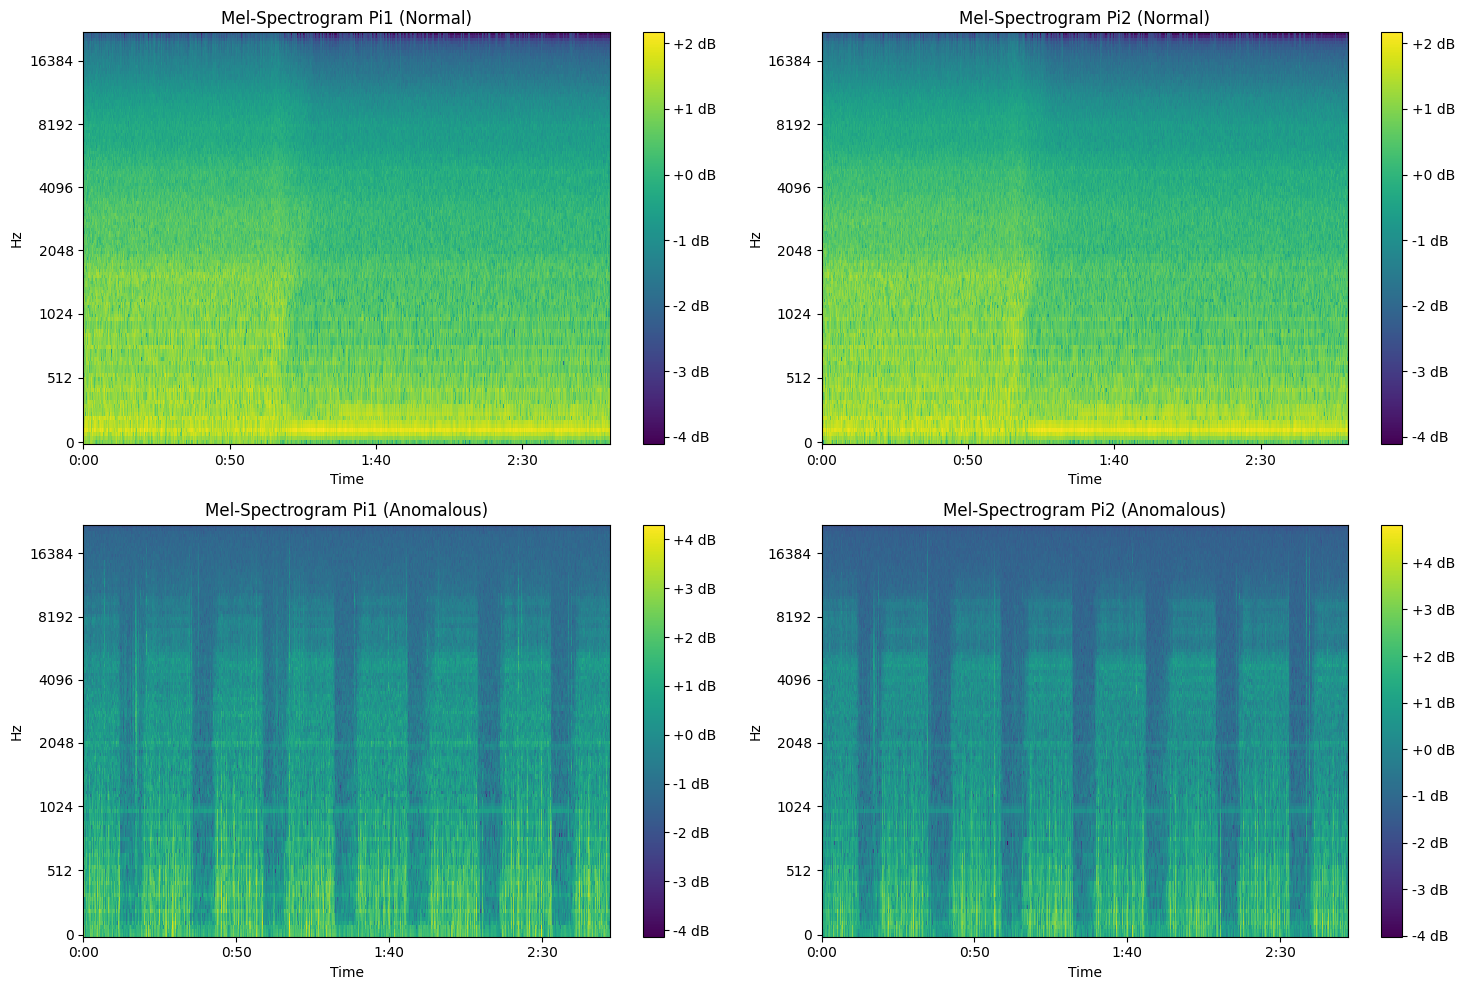

In [9]:
# Create a figure for the subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 0])
axs[0, 0].set(title='Mel-Spectrogram Pi1 (Normal)')
fig.colorbar(img1, ax=axs[0, 0], format='%+2.0f dB')

# Plot Normal Pi2
img2 = librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 1])
axs[0, 1].set(title='Mel-Spectrogram Pi2 (Normal)')
fig.colorbar(img2, ax=axs[0, 1], format='%+2.0f dB')

# Plot Anomalous Pi1
img3 = librosa.display.specshow(mel_db_Api1, sr=sr3, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 0])
axs[1, 0].set(title='Mel-Spectrogram Pi1 (Anomalous)')
fig.colorbar(img3, ax=axs[1, 0], format='%+2.0f dB')

# Plot Anomalous Pi2
img4 = librosa.display.specshow(mel_db_Api2, sr=sr4, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 1])
axs[1, 1].set(title='Mel-Spectrogram Pi2 (Anomalous)')
fig.colorbar(img4, ax=axs[1, 1], format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrograms_comparison.png')
plt.show()

## **3. Frame Generation**

In [26]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]

    return frames

# Generate frames for normal Pi1 and Pi2
frames_pi1 = generate_frames(mel_db_pi1)
frames_pi2 = generate_frames(mel_db_pi2)

# Generate frames for anomalous Pi1 and Pi2
frames_Api1 = generate_frames(mel_db_Api1)
frames_Api2 = generate_frames(mel_db_Api2)

print(f"Frames Pi1 (Normal): {frames_pi1.shape}")
print(f"Frames Pi2 (Normal): {frames_pi2.shape}")
print(f"Frames Api1 (Anomalous): {frames_Api1.shape}")
print(f"Frames Api2 (Anomalous): {frames_Api2.shape}")

Frames Pi1 (Normal): (241, 128, 128)
Frames Pi2 (Normal): (241, 128, 128)
Frames Api1 (Anomalous): (230, 128, 128)
Frames Api2 (Anomalous): (230, 128, 128)


## Imports and Helper Functions

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import librosa

# Helper function to convert complex numbers to real
def convert_complex_to_real(value):
    return complex(value).real

# Feature extraction function (assuming a simplified version for demonstration)
def get_features(filename, n_fft=2048, sr=22050, means=False):
    ''' Extracts MFCC, Log Mel energy, and Chroma (CENS) features '''
    y, sr = librosa.load(filename, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    log_mel = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft), ref=np.max)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    
    features = np.hstack([mfcc, log_mel, chroma])
    if means:
        features = np.mean(features, axis=1)
    
    return features

# Function to apply feature extraction on a DataFrame
def get_df_feat(df, n_fft=2048, sr=22050, means=False):
    feat_cols = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = row['filename']
        feat = get_features(filename, n_fft=n_fft, sr=sr, means=means)
        feat_cols.append(feat)
    feat_df = pd.DataFrame(feat_cols)
    feat_df = feat_df.applymap(convert_complex_to_real)
    return feat_df

# **4 Benchmark**

## 4.1 Preprocessing and Model Evaluation Function

In [ ]:
# Combine normal and anomalous data into training and testing sets
X_train = np.vstack([frames_pi1.reshape(len(frames_pi1), -1), frames_pi2.reshape(len(frames_pi2), -1)])
X_test = np.vstack([
    frames_pi1.reshape(len(frames_pi1), -1),
    frames_pi2.reshape(len(frames_pi2), -1),
    frames_Api1.reshape(len(frames_Api1), -1),
    frames_Api2.reshape(len(frames_Api2), -1),
])
y_test = np.array([1] * (len(frames_pi1) + len(frames_pi2)) + [-1] * (len(frames_Api1) + len(frames_Api2)))

## 4.2 Data preparation

In [29]:
def classify_anomalies(train_data, test_data, test_labels, machine, feat_label):
    scaler = MinMaxScaler((-5, 5))
    
    # Model pipelines
    lof = LocalOutlierFactor(novelty=True, contamination=0.1)
    pca_lof = PCA(0.9)
    lof_pipe = Pipeline([("scaler", scaler), ("classifier", lof)])
    lof_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_lof), ("classifier", lof)])
    
    isolation_forest = IsolationForest(contamination=0.1)
    pca_if = PCA(0.9)
    isolation_forest_pipe = Pipeline([("scaler", scaler), ("classifier", isolation_forest)])
    isolation_forest_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_if), ("classifier", isolation_forest)])
    
    models = {
        "LOF": lof_pipe,
        "LOF + PCA": lof_pca_pipe,
        "Isolation Forest": isolation_forest_pipe,
        "Isolation Forest + PCA": isolation_forest_pca_pipe,
    }
    
    results = {
        "Machine": machine,
        "Features": feat_label,
        "Model": [],
        "AUC": [],
        "Recall": [],
        "Precision": [],
        "Abnormal (-1) F1": [],
    }
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(16, 4))

    for i, (model_name, model) in enumerate(models.items()):
        roc_ax = axes[i]
        model.fit(train_data)
        scores = model.decision_function(test_data)
        auc = roc_auc_score(test_labels, scores)
        fpr, tpr, thresholds = roc_curve(test_labels, scores)
        
        roc_ax.plot(fpr, tpr)
        roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)
        roc_ax.set_title(f'{model_name}\n ROC Curve\n AUC = {auc:.2f}')
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.legend(['ROC curve', 'Random'], fontsize="9", loc='lower right')

        # Threshold for 85% correctly classified normal data
        sorted_scores = np.sort(thresholds)
        threshold_index = int(0.85 * len(sorted_scores))
        threshold = sorted_scores[threshold_index]
        predictions = np.where(scores >= threshold, 1, -1)

        recall = recall_score(test_labels, predictions, pos_label=-1)
        precision = precision_score(test_labels, predictions, pos_label=-1)
        abf1 = f1_score(test_labels, predictions, pos_label=-1)
        
        results["Model"].append(model_name)
        results["AUC"].append(auc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["Abnormal (-1) F1"].append(abf1)

    results_df = pd.DataFrame(results)
    print(f"{feat_label} features were reduced to {pca_lof.n_components_} components for LOF")
    print(f"{feat_label} features were reduced to {pca_if.n_components_} components for Isolation Forest")
    plt.tight_layout()
    plt.show()
    
    return results_df

## 4.3 Classification

MFCC, Log Mel, Chroma features were reduced to 154 components for LOF
MFCC, Log Mel, Chroma features were reduced to 154 components for Isolation Forest


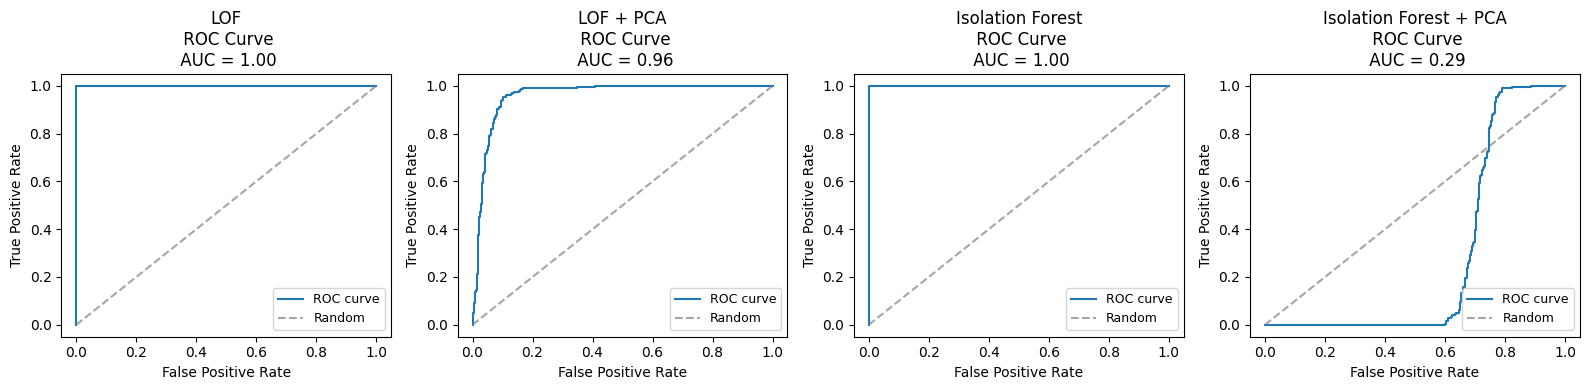

              Machine               Features                   Model  \
0  Hydropower Machine  MFCC, Log Mel, Chroma                     LOF   
1  Hydropower Machine  MFCC, Log Mel, Chroma               LOF + PCA   
2  Hydropower Machine  MFCC, Log Mel, Chroma        Isolation Forest   
3  Hydropower Machine  MFCC, Log Mel, Chroma  Isolation Forest + PCA   

        AUC    Recall  Precision  Abnormal (-1) F1  
0  1.000000  1.000000   0.488323          0.656205  
1  0.959336  0.986957   0.523041          0.683735  
2  1.000000  1.000000   0.488323          0.656205  
3  0.290583  0.363043   0.267200          0.307834  


In [30]:
results_df = classify_anomalies(X_train, X_test, y_test, "Hydropower Machine", "MFCC, Log Mel, Chroma")
print(results_df)

## 4.1 Architecture

In [ ]:
import numpy as np
import librosa
from util import play_audio, load_audio, get_features, get_mfcc, get_lmfe, get_chroma, plot_chroma, plot_mfcc, plot_lmfe
from tqdm.notebook import trange, tqdm
import pandas as pd
import glob
import scipy
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns

sns.set(style="white", palette="muted")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [ ]:
def convert_complex_to_real(value):
    return complex(value).real

def printmd(string):
    display(Markdown(string))
    
def get_df_feat(df, n_fft, sr, means=False):
    ''' Used to extract Features from spectrograms 
    MFCC, Log mel energy and Chroma (CENS)
    '''
    feat_cols = []

    # Initialize the progress bar
    progress_bar = tqdm(total=len(df), position=0, leave=True)
    for i, row in df.iterrows():
        filename = row['filename']
        feat, labels = get_features(filename, n_fft, sr, frac=10, means=means)

        feat_cols.append(feat)
        lab_cols = labels
        # Update the progress bar
        progress_bar.update(1)

    feat_array = np.vstack(feat_cols)
    lab_array = lab_cols.flatten()

    feat_df = pd.DataFrame(feat_array, columns=list(lab_array), index=df.index)

    # Convert complex numbers to real values
    feat_df = feat_df.applymap(convert_complex_to_real)

    # Assign the columns to the original DataFrame
    df = pd.concat([df, feat_df], axis=1)

    return df

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16384, bias=True)
    (3): Sigmoid()
    (4): Unflatten(dim=1, unflattened_size=(128, 128))
  )
)


## 4.2 Data preparation

In [ ]:
rom sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


def classify_anomalies(train_data, test_data, test_labels, machine, feat_label):
    scaler = MinMaxScaler((-5, 5))
    
    # LOF without PCA
    lof = LocalOutlierFactor(novelty=True, contamination=0.0001)
    lof_pipe = Pipeline([("scaler", scaler), ("classifier", lof)])
    
    # LOF with PCA
    pca_lof = PCA(0.9)
    lof_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_lof), ("classifier", lof)])
    
    # Isolation Forest without PCA
    isolation_forest = IsolationForest(contamination=0.0001)
    isolation_forest_pipe = Pipeline([("scaler", scaler), ("classifier", isolation_forest)])
    
    # Isolation Forest with PCA
    pca_if = PCA(0.9)
    isolation_forest_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_if), ("classifier", isolation_forest)])

    models = {
        "LOF": lof_pipe,
        "LOF + PCA": lof_pca_pipe,
        "Isolation Forest": isolation_forest_pipe,
        "Isolation Forest + PCA": isolation_forest_pca_pipe,
    }

    results = {
        "Machine": machine,
        "Features": feat_label,
        "Model": [],
        "AUC": [],
        "Recall": [],
        "Precision": [],
        "Abnormal (-1) F1": [],
    }
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(16, 4))

    for i, (model_name, model) in enumerate(models.items()):
        roc_ax = axes[i]
        model.fit(train_data)
        scores = model.decision_function(test_data)
        auc = roc_auc_score(test_labels, scores)  # Use -scores because higher score should be less anomalous
        fpr, tpr, thresholds = roc_curve(test_labels, scores)
        # Plot the ROC curve
        roc_ax.plot(fpr, tpr)
        roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)  # Diagonal line for reference
        roc_ax.set_title(f'{model_name}\n ROC Curve\n AUC = {auc:.2f}')
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.legend(['ROC curve', 'Random'], fontsize="9", loc='lower right')

        # Sort scores in ascending order and find the threshold for 85% correctly classified normal data
        sorted_scores = np.sort(thresholds)
        threshold_index = int(0.85 * len(sorted_scores))
        threshold = sorted_scores[threshold_index]

        # Make predictions based on the threshold
        predictions = np.where(scores >= threshold, 1, -1)
        recall = recall_score(test_labels, predictions, average='weighted')
        precision = precision_score(test_labels, predictions, average='weighted')
        abf1 = metrics.f1_score(test_labels, predictions, pos_label= -1, average='binary')

        results["Model"].append(model_name)
        results["AUC"].append(auc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["Abnormal (-1) F1"].append(abf1)

    results_df = pd.DataFrame(results)
    print(f"{feat_label} features were reduced to {pca_lof.n_components_} components for LOF")
    print(f"{feat_label} features were reduced to {pca_if.n_components_} components for Isolation Forest")
    return results_df